# scikit-learnのサンプルデータセットを使って、簡単な機械学習をしてみよう！

今回は機械学習界隈におけるHelloWorld的なアイリスデータセット（アヤメの種類のデータ）を使います。\
アヤメはがくの幅と長さ、花びらの幅と長さで種類が決まるため、データ分類の入門として扱いやすい存在ためです。

必要なデータはそれぞれ以下となります。
1. Sepal Length(cm) がくの長さ
2. Sepal Width がくの幅
3. Petal length 花びらの長さ
4. petal Width 花びらの幅


また、用意されている種別は3つです。
- [setosa（セトサ）](https://www.fs.fed.us/wildflowers/beauty/iris/Blue_Flag/iris_setosa.shtml)
- [versicolor（バージカラー）](https://www.fs.fed.us/wildflowers/beauty/iris/Blue_Flag/iris_versicolor.shtml)
- [virginica（バージニカ）](https://www.fs.fed.us/wildflowers/beauty/iris/Blue_Flag/iris_virginica.shtml) ※ 今回は使わない

## コードを書いていこう！

### データの下準備

まずは必要なパッケージとデータセットをインポートしましょう。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import random

iris = datasets.load_iris()
iris_data = iris.data
sl_data = iris_data[:100, 0] # SetosaとVersicolorに関するSepal lengthのデータ
sw_data = iris_data[:100, 1] # SetosaとVersicolorに関するSepal widthのデータ

機械学習をする上では、正負のデータのバランスが良い方が好ましいです。（学習させやすい）\
そのため、平均値を引いてあげてバランスを整えましょう。

In [2]:
sl_ave = np.average(sl_data)  # 平均値を算出
sl_data -= sl_ave  # 平均値を引くことで平均値=0にする
sw_ave = np.average(sw_data)
sw_data -= sw_ave

# 整えたデータをリストに格納する（これが学習用データとなる）
train_data = []
for i in range(100):
    correct = iris.target[i]
    train_data.append([sl_data[i], sw_data[i], correct])

### ニューラルネットワークの作成

ニューロンの中にある**活性化関数**を用意します。\
活性化関数には[シグモイド関数](https://atmarkit.itmedia.co.jp/ait/articles/2003/04/news021.html)を使用します。\
詳細は割愛しますが、シグモイド関数は点対称となるS字型の滑らかな曲線を描く関数で、0~1の間の値を返します。\
そのため、2つに分類するタイプの計算に用いられやすい関数です。

In [3]:
# シグモイド関数の公式
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

続いて、ニューロンを定義します。\
入力と出力ができるようにsetterとgetterを定義しましょう。

In [4]:
# ニューロン
class Neuron:
    def __init__(self):
        self.input_sum = 0.0
        self.output = 0.0

    def set_input(self, inp):
        self.input_sum += inp

    def get_output(self):
        self.output = sigmoid(self.input_sum)
        return self.output

    def reset(self):
        self.input_sum = 0
        self.output = 0

次はニューラルネットワークの構築です。\
今しがた定義したニューロンのインスタンスを生成し、入力層・中間層・出力層の3つを宣言しましょう。\

In [5]:
# ニューラルネットワーク
class NeuralNetwork:
    def __init__(self):
        # 重み（固定）
        self.w_im = [[4.0, 4.0], [4.0, 4.0], [4.0, 4.0]]  # 入力は2つ ニューロンは3つ
        self.w_mo = [[1.0, -1.0, 1.0]]  # 入力は3つ ニューロンは1つ

        # バイアス（固定）
        self.b_m = [3.0, 0.0, -3.0]  # ニューロンは3つ
        self.b_o = [-0.5]  # ニューロンは1つ

        self.input_layer = [0.0, 0.0] # 入力層
        self.middle_layer = [Neuron(), Neuron(), Neuron()] # 中間層
        self.output_layer = [Neuron()] # 出力層

    def commit(self, input_data):
        # 入力層にデータを渡す
        self.input_layer[0] = input_data[0]
        self.input_layer[1] = input_data[1]
        # 中間層と出力層を初期化
        self.middle_layer[0].reset()
        self.middle_layer[1].reset()
        self.middle_layer[2].reset()
        self.output_layer[0].reset()

        # 入力層→中間層1つ目
        self.middle_layer[0].set_input(self.input_layer[0] * self.w_im[0][0])
        self.middle_layer[0].set_input(self.input_layer[1] * self.w_im[0][1])
        self.middle_layer[0].set_input(self.b_m[0])

        # 入力層→中間層2つ目
        self.middle_layer[1].set_input(self.input_layer[0] * self.w_im[1][0])
        self.middle_layer[1].set_input(self.input_layer[1] * self.w_im[1][1])
        self.middle_layer[1].set_input(self.b_m[1])

        # 入力層→中間層3つ目
        self.middle_layer[2].set_input(self.input_layer[0] * self.w_im[2][0])
        self.middle_layer[2].set_input(self.input_layer[1] * self.w_im[2][1])
        self.middle_layer[2].set_input(self.b_m[2])

        # 中間層→出力層
        self.output_layer[0].set_input(self.middle_layer[0].get_output() * self.w_mo[0][0])
        self.output_layer[0].set_input(self.middle_layer[1].get_output() * self.w_mo[0][1])
        self.output_layer[0].set_input(self.middle_layer[2].get_output() * self.w_mo[0][2])
        self.output_layer[0].set_input(self.b_o[0])

        return self.output_layer[0].get_output()

    def train(self, correct):
        # 学習係数
        k = 0.3

        #  出力
        output_o = self.output_layer[0].output
        output_m0 = self.middle_layer[0].output
        output_m1 = self.middle_layer[1].output
        output_m2 = self.middle_layer[2].output

        # δ
        delta_o = (output_o - correct) * output_o * (1.0 - output_o)
        delta_m0 = delta_o * self.w_mo[0][0] * output_m0 * (1.0 - output_m0)
        delta_m1 = delta_o * self.w_mo[0][1] * output_m1 * (1.0 - output_m1)
        delta_m2 = delta_o * self.w_mo[0][2] * output_m2 * (1.0 - output_m2)

        # パラメータの更新
        self.w_mo[0][0] -= k * delta_o * output_m0
        self.w_mo[0][1] -= k * delta_o * output_m1
        self.w_mo[0][2] -= k * delta_o * output_m2
        self.b_o[0] -= k * delta_o

        self.w_im[0][0] -= k * delta_m0 * self.input_layer[0]
        self.w_im[0][1] -= k * delta_m0 * self.input_layer[1]
        self.w_im[1][0] -= k * delta_m1 * self.input_layer[0]
        self.w_im[1][1] -= k * delta_m1 * self.input_layer[1]
        self.w_im[2][0] -= k * delta_m2 * self.input_layer[0]
        self.w_im[2][1] -= k * delta_m2 * self.input_layer[1]
        self.b_m[0] -= k * delta_m0 
        self.b_m[1] -= k * delta_m1 
        self.b_m[2] -= k * delta_m2

# ニューラルネットワークのインスタンスを生成する
neural_network = NeuralNetwork()

途中で出てきた「δ（デルタ）」は誤差逆伝播法を表します。\
正直微分とか出まくりで分かりにくいのですが、ざっくり説明しますと、\
出力層→中間層→入力層へと遡りつつ、本来出力されるべき値と実際の出力結果との誤差を見てパラメータを調整する方法のことです。\（入力層から出力層まで学習させていくことは順伝播法と言います。）

【余談】\
もともとニューラルネットワークは3層までが限界だったのですが、この逆伝播法が登場したことで学習効率が飛躍的に良くなり、3層を超えてニューラルネットワークを構築することができるようになりました。\
その結果ディープラーニングができるようになったので、実はすごいブレイクスルーなのです。

### 学習結果の可視化

ここまで来たらあと少しです。\
学習結果を見やすくするための関数を用意しましょう。

Epoch: 0


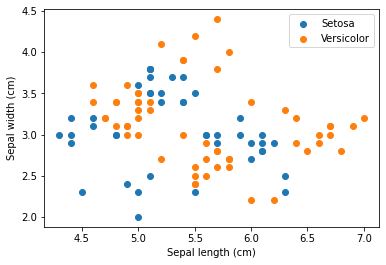

In [6]:
def show_graph(epoch):
    print("Epoch:", epoch)

    st_predicted = [[], []]  # Setosaに分類されるもの
    vc_predicted = [[], []]  # Versicolorに分類されるもの
    for data in train_data:
        if neural_network.commit(data) < 0.5:
            st_predicted[0].append(data[0]+sl_ave)
            st_predicted[1].append(data[1]+sw_ave)
        else:
            vc_predicted[0].append(data[0]+sl_ave)
            vc_predicted[1].append(data[1]+sw_ave)

    # 分類結果をグラフで表示する
    plt.scatter(st_predicted[0], st_predicted[1], label="Setosa")
    plt.scatter(vc_predicted[0], vc_predicted[1], label="Versicolor")
    plt.legend()

    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.show()

# グラフで表示
show_graph(0)

さて、それではデータを学習させてみましょう。

Epoch: 1


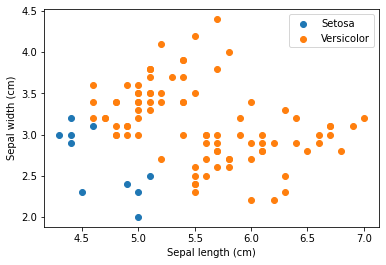

Epoch: 2


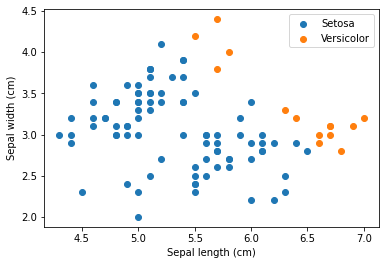

Epoch: 4


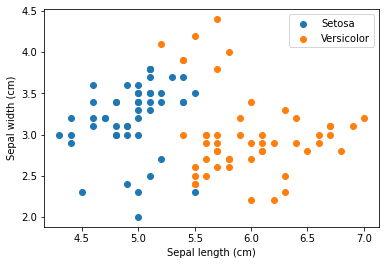

Epoch: 8


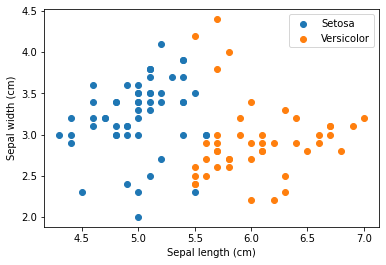

Epoch: 16


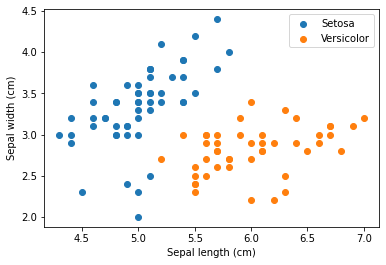

Epoch: 32


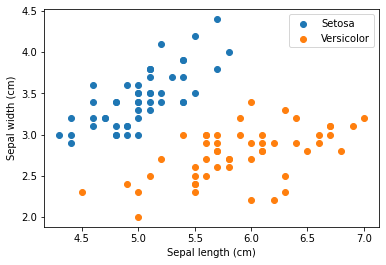

Epoch: 64


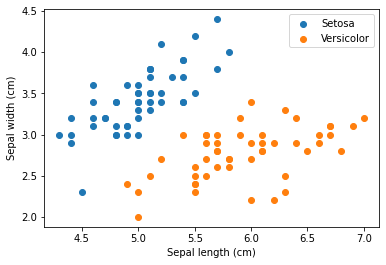

In [7]:
for t in range(0, 64):
    random.shuffle(train_data)
    for data in train_data:
        neural_network.commit(data[:2])  # 順伝播
        neural_network.train(data[2])  # 逆伝播
    # 一定回数学習するごとにグラフで表示する
    if t+1 in [1, 2, 4, 8, 16, 32, 64]:
        show_graph(t+1)

せっかくなので、比較用にもとの正しい状態の分類も表示してみましょう。

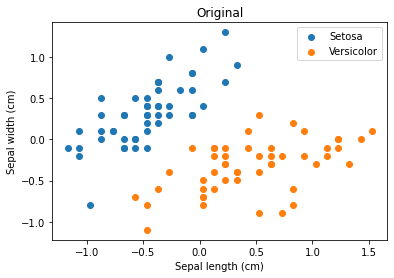

In [8]:
st_data = iris_data[:50]  # Setosaのデータ
vc_data = iris_data[50:100]  # Versicolorのデータ
plt.scatter(st_data[:, 0], st_data[:, 1], label="Setosa")
plt.scatter(vc_data[:, 0], vc_data[:, 1], label="Versicolor")
plt.legend()

plt.xlabel("Sepal length (cm)")
plt.ylabel("Sepal width (cm)")
plt.title("Original")
plt.show()

## 終わりに

これが基本的な機械学習の流れになります！\
実用的な学習をさせるためには数百~数億のパラメータが必要になるため、学習には手間も時間もかかります。\
そもそもの学習モデルが正しいかどうかも分からないので、地道に学習を繰り返していくか、知見の豊富な方にご助力いただくかしないと厳しいかもしれません。\

ですが、身の回りのちょっとした学習程度であれば、今回のように触って楽しみながら学んでいくことができると思います。\
このノートブックが機械学習入門へのきっかけになれば嬉しいです！

### 謝辞

このコードは「[みんなのAI講座 ゼロからPythonで学ぶ人工知能と機械学習](https://github.com/yukinaga/minnano_ai)」を参考にさせていただきました。\
Udemyの講座も分かりやすく、機械学習の楽しさに気づくことができました。\
素晴らしい講座をありがとうございます。